# Test and debug Kalman filter v1

---

## Equations verified by the simulator

$$
\begin{align}
(1+a) m \frac{d^2z_f}{dt^2} = 
- mg
+ mg \frac{\rho_w}{\rho_f}
- m \frac{c_1}{2L} \Big |\frac{dz_f}{dt} - w \Big | \Big ( \frac{dz_f}{dt} - w \Big )
\end{align}
$$

## Equations employed by the Kalman filter

The Kalman state vector is:

$$
\begin{align*}
\underline{x} &= 
\left(\begin{array}{c} 
x_0\\
x_1\\
x_2\\
x_3\\
x_4\\
x_5\\
\end{array}\right)
=
\left(\begin{array}{c} 
-dz_f/dt\\
-z_f\\
V_e \\
\gamma_{e,1} \\
\gamma_{e,2} \\
c1
\end{array}\right)
\end{align*}
$$

Variables estimated by the Kalman filter are therefore the depth temporal rate of evolution ($x_0$, in m/s), depth ($x_1$, in m), equivalent compressibility ($\gamma_e$, in m$^2$) and the equivalent volume ($x_3$,  in m$^3$).

The Kalman filter dynamical equation is:

$$
\begin{align}
d\underline{x}/dt &= 
\left(\begin{array}{c} 
dx_0/dt\\
dx_1/dt\\
dx_2/dt\\
dx_3/dt\\
dx_4/dt\\
dx_5/dt
\end{array}\right)
=
\left(\begin{array}{c} 
-d^2z_f/dt^2\\
-dz_f/dt\\
0\\
0\\
0\\
0
\end{array}\right)
= 
\left(\begin{array}{c} 
-A (x_3 - x_2 x_1 +v) - B |x_0| x_0 \\
x_0\\
0 \\
0 \\
0 \\
0
\end{array}\right), \label{eq:dxdt}
\end{align}
$$

, where several parameters have been introduced: $A = g\rho/2m$ and $B = c_1/4L$.


\begin{align}
(1+a) m \frac{d^2z_f}{dt^2} = 
g \rho (V_e + \gamma_{e,1} z + \gamma_{e,2} z^2 + v)
- m \frac{c_1}{2L} \Big |\frac{dz_f}{dt} \Big | \Big ( \frac{dz_f}{dt} \Big )
\end{align}

where $V_e= V_0 [\delta\rho_w(\overline{z}) - \overline{z} \partial_z \rho_w ]/\rho$, $\gamma_e = V_0 \partial_z \rho_w /\rho + \gamma_V$, and, $\overline{z}$ is the averaged vertical level the float is moving around.


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from copy import deepcopy

import cognac.float as fl

WOA water profile at lon=6, lat=40


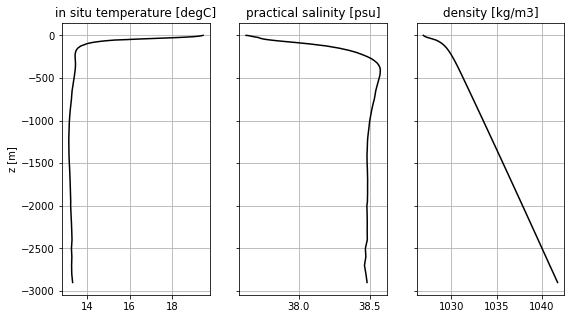

In [2]:
# select a water profile
#w = fl.waterp(lon=-50.,lat=40.) # Gulf Stream
w = fl.waterp(lon=6.,lat=40.) # Mediterranean sea
print(w)

--- 
## Instantiate the float object

In [3]:
# Init now active control of the vertical position

#
z=np.arange(-500.,0.,1.)
rho_w, p, temp = w.get_rho(z), w.get_p(z), w.get_temp(z)

#
f = fl.autonomous_float(model='Ifremer')
f.init_piston()
print(f)

# adjust mass to be at equilibrium at 0m and substract 5g
iz = np.argmin(np.abs(z+0))
f.adjust_m(p[iz],temp[iz],rho_w[iz], offset=-5)

# compute bounds on motions
fmax, fmin, afmax, wmax = f.compute_bounds(w,-500.)

Piston max volume set from max displacement
Float parameters: 
  L     = 0.83 m      - float length
  r     = 0.07 m      - float radius
  m     = 11.63 kg     - float mass
  V     = 1.27e+04 cm^3   - float volume
  rho_cte = m/V = 9.13e+08 kg.cm^3   - float baseline density
  gamma = 3.78e-06 /dbar  - mechanical compressibility
  gamma x V = 4.82e-02 cm^3/dbar  - normalized compressibility
  alpha = 6.98e-05 /degC  - thermal compressibility
  alpha x V = 8.89e-01 cm^3/degC  - normalized thermal compressibility
  temp0 = 0.00e+00  degC  - reference temperature
  a = 1.00e+00  (no dimension)  - float added mass
  c0 = 0.00e+00  (no dimension)  - float drag parameter 0
  c1 = 1.00e+00  (no dimension)  - float drag parameter 1
Piston parameters and state: 
  r     = 0.97 cm        - piston radius
  d     = 0.00 cm        - present piston displacement
  vol   = 26.88 cm^3      - present volume addition
  d_increment  = 8.57e-02 mm        - smallest variation of translation motion for the p

Piston reset for equilibrium : vol=2.2e+01 cm^3  
z equilibrium = -1.0m


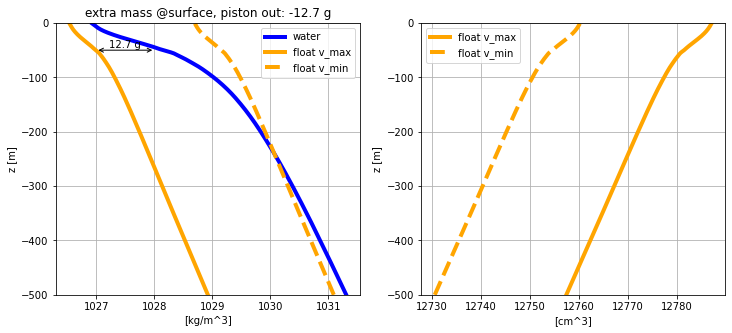

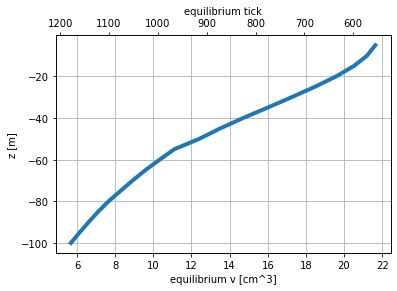

In [4]:
# adjust piston to be at equilibrium -1m
z0 = -1.
iz = np.argmin(np.abs(z-z0))
vstart = f.set_piston4equilibrium(p[iz],temp[iz],rho_w[iz])
print('z equilibrium = %.1fm' %(f.z4equilibrium(w) ) )

# show densities
fig, ax = plt.subplots(1, 2, figsize=(12,5))
fl.plot_float_density(z, f, w, ax=ax[0])
_ = fl.plot_float_volume(z, f, w, ax=ax[1])
_ = fl.plot_equilibrium_volume(f, w)

In [5]:
# physical parameters used for kalman parameters

delta_rho = 2 # [kg/m3] change of water density over the depth of interest 
L_rho = 100 # [m] characteristic length scale for water density changes
V_e_rho = f.V*delta_rho/f.rho_cte # back of the envelope estimate for V_e
acceleration_rho = 0.5*fl.g*delta_rho/f.rho_cte

print('delta_rho = {:.2e} kg/m^3'.format(delta_rho))
print('L_rho = {:.2e} m'.format(L_rho))
print('V_e_rho = {:.2e} m'.format(V_e_rho))
print('acceleration_rho = {:.2e} m/s2'.format(acceleration_rho))
print('acceleration 0 to 10cm in 10s = {:.2e} m/s2'.format(0.1/10))

delta_rho = 2.00e+00 kg/m^3
L_rho = 1.00e+02 m
V_e_rho = 2.47e-05 m
acceleration_rho = 9.52e-03 m/s2
acceleration 0 to 10cm in 10s = 1.00e-02 m/s2


### equivalent volume and compressibilities

The float dynamics may be simplified and expressed as:

\begin{align}
2m\frac{d^2z_f}{dt^2}
+ m\frac{c_1}{2L} \Big |\frac{dz_f}{dt} \Big | \frac{dz_f}{dt} = 
g \rho (V_e + \gamma_e z + v),
\label{eq:zf_reg3}
\end{align}

where $V_e= V_0 [\delta\rho_w(\overline{z}) - \overline{z} \partial_z \rho_w ]/\rho$, $\gamma_e = V_0 \partial_z \rho_w /\rho + \gamma_V$, and, $\overline{z}$ is the averaged vertical level the float is moving around.


Back of the envelope estimate of V_e: 2.5e+01 cm^3


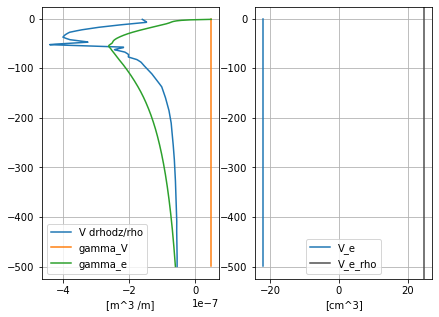

In [6]:
zm = (z[1:]+z[:-1])*.5

## linearization around local z (z bar)
V_e = f.V*( (rho_w[:-1]+rho_w[1:])*.5 - f.rho_cte 
           - zm*np.diff(rho_w)/np.diff(z)
          )/f.rho_cte
# V_e should be 0 at balasting point (surface, vol_max):
_dV_surf =  (f.compute_force(0., 0., w, 1., v=f.piston.vol_max))/(9.81*f.rho_cte) \
           - f.piston.vol_max
V_e = V_e - V_e[-1] + _dV_surf
    
gamma_V = f.V*f.gamma
gamma_rho = f.V*np.diff(rho_w)/f.rho_cte/np.diff(z)
gamma_e = gamma_rho + gamma_V

## linearization from surface down 
if True:
    V_e = f.V* (rho_w[:-1]+rho_w[1:])*.5/f.rho_cte
    V_e = V_e - V_e[-1] + _dV_surf
    gamma_e =  (V_e - _dV_surf)/zm + gamma_V
    V_e = V_e*0. + _dV_surf

V_e100 = interp1d(zm, V_e, kind='linear')(-25)
gamma_e100 = interp1d(zm, gamma_e, kind='linear')(-25)

plt.figure(figsize=(7,5))
ax=plt.subplot(121)
ax.plot(gamma_rho, zm, label='V drhodz/rho')
ax.plot(gamma_V+0.*zm, zm, label='gamma_V')
ax.plot(gamma_e, zm, label='gamma_e')
ax.grid()
ax.legend(loc=3)
ax.set_xlabel('[m^3 /m]')

ax=plt.subplot(122)
ax.plot(V_e*1e6, zm, label='V_e')
ax.axvline(x=V_e_rho*1e6, color='0.3',label='V_e_rho')
ax.grid()
ax.legend()
ax.set_xlabel('[cm^3]')

print('Back of the envelope estimate of V_e: %.1e cm^3' %(V_e_rho*1e6))

---

### set up desired trajectory

In [7]:
# we start by constructing a trajectory that can be followed by the float
target_velocity = 0.1
z_target = fl.descent(3600, -20., wmax=10., zstart=z0)

Tsim = 1000.

f0 = deepcopy(f)

---

### Kalman filter with exact dynamical system

The true dynamical equation is reset to that used by the Kalman and regulation:

\begin{align}
(1+a) m \frac{d^2z_f}{dt^2} = 
g \rho (V_e + \gamma_e z + v)
- m \frac{c_1}{2L} \Big |\frac{dz_f}{dt} \Big | \Big ( \frac{dz_f}{dt} \Big )
\end{align}

In [8]:
# use PID for control to decouple Kalman filtering from control
u = f.piston.u_max/4.
delta = 10. # m
tau = 15. # time scale

_c = {'mode': 'pid', 'dt': 10.,
      'Kp': u/delta, 'Ki': u/delta/tau*0., 'Kd': u/delta*tau*0., 
      'dz_nochattering': 0.}

In [9]:
V_e_cst = -f.piston.vol_max/2.
gamma_e1_cst = -5*f.gammaV
gamma_e2_cst = -5*f.gammaV/100.

def _compute_force(z, w, waterp, Lv, v=None, sum=False):
    g = 9.81
    f_b = g * f.rho_cte * (V_e_cst + gamma_e1_cst * z + gamma_e2_cst * z**2 + v)
    f_d = - f.m * f.c1/2/Lv * np.abs(w) * w
    if sum:
        return f_b+f_d
    else:
        return f_b+f_d, f_b, f_d
    
f.compute_force = _compute_force

In [10]:
long_time_scale = 1e3 # time scale used to scale V_e and gamma_e time rate of change

# general kalman filter parameters
_k = {'version': 'v1', 'dt':.5, 'depth_error': 1e-1}
# initial state vector
_k.update({'x_init': [0., 0., 0., 0., 0., 0.]})
# initial state covariance:
_k.update({'gamma_init':np.array([_k['depth_error']/_k['dt'],
                                  _k['depth_error'],
                                  V_e_cst,
                                  f.gammaV,
                                  f.gammaV/100., # 100m
                                  1.
                                ])**2
          })
# dynamics covariance:
_k.update({'gamma_alpha_scaled': np.array([acceleration_rho/1e1,
                                           acceleration_rho*_k['dt']/1e2,
                                           V_e_cst/long_time_scale,
                                           f.gammaV/long_time_scale,
                                           f.gammaV/100./long_time_scale, # 100m
                                           1./long_time_scale
                                          ])**2
          })
# observation error covariance:
_k.update({'gamma_beta': np.diag([_k['depth_error']**2])})

f.time_step(w,T=Tsim, dt_step=.1, dt_log=1., z=z0, w=0., v=vstart,
            piston=True, z_target=z_target, ctrl=_c, kalman=_k, verbose=0)

Kalman filter: 
  dt     = 0.50 s     - filter time step
  x_hat   = [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00] - kalman state 
  sqrt(diag(gamma)): [2.00e-01 1.00e-01 1.34e-05 4.82e-08 4.82e-10 1.00e+00]
  sqrt(gamma_alpha) / dt: [9.52e-04 4.76e-05 1.34e-08 4.82e-11 4.82e-13 1.00e-03]
  sqrt(gamma_beta): [1.00e-01]
Start time stepping for 16 min ...
... time stepping done


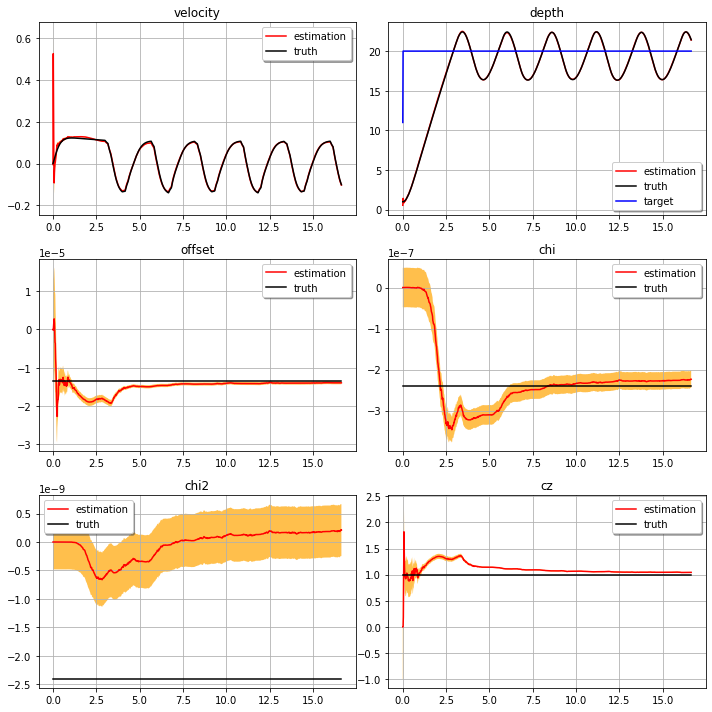

In [11]:
_t = -(f.log['state']._df
       .set_index('time')[['w','z']]
       .rename(columns={'w': 'x_0', 'z': 'x_1'})
      )
_t['x_2'] = V_e_cst + _t['x_0']*0.
_t['x_3'] = gamma_e1_cst + _t['x_0']*0.
_t['x_4'] = gamma_e2_cst + _t['x_0']*0.
_t['x_5'] = 1. + _t['x_0']*0.

fl.plot_kalman(f.log, f, z_target=z_target, truth=_t, figsize=(10,10))

### turn off gamma_e2

Acceleration error may need to be increased to account for larger errors

Kalman filter: 
  dt     = 0.50 s     - filter time step
  x_hat   = [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00] - kalman state 
  sqrt(diag(gamma)): [2.00e-01 1.00e-01 1.34e-05 4.82e-08 4.82e-16 1.00e+00]
  sqrt(gamma_alpha) / dt: [9.52e-04 4.76e-05 1.34e-08 4.82e-11 4.82e-19 1.00e-03]
  sqrt(gamma_beta): [1.00e-01]
Start time stepping for 16 min ...
... time stepping done


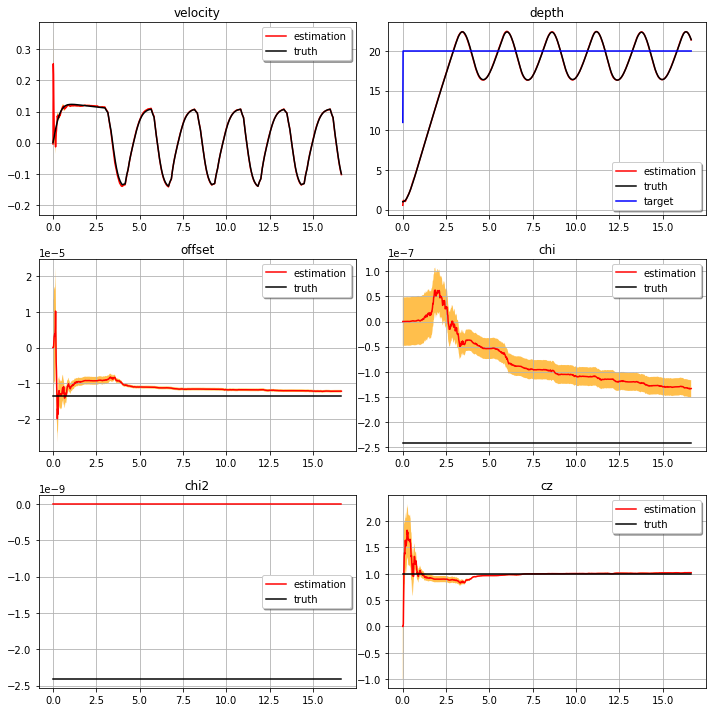

In [12]:
scale = 1e-6 # parameter use to turn off role of equivalent compressibility

_k.update({'gamma_init':np.array([_k['depth_error']/_k['dt'],
                                  _k['depth_error'],
                                  V_e_cst,
                                  f.gammaV,
                                  f.gammaV/100.*scale, # 100m
                                  1.
                                ])**2
          })
# dynamics covariance:
_k.update({'gamma_alpha_scaled': np.array([acceleration_rho /1e1,
                                           acceleration_rho*_k['dt'] /1e2,
                                           V_e_cst/long_time_scale,
                                           f.gammaV/long_time_scale,
                                           f.gammaV/100./long_time_scale*scale, # 100m
                                           1./long_time_scale
                                          ])**2
          })


f.time_step(w,T=Tsim, dt_step=.1, dt_log=1., z=z0, w=0., v=vstart,
            piston=True, z_target=z_target, ctrl=_c, kalman=_k, verbose=0)

_t = -(f.log['state']._df
       .set_index('time')[['w','z']]
       .rename(columns={'w': 'x_0', 'z': 'x_1'})
      )
_t['x_2'] = V_e_cst + _t['x_0']*0.
_t['x_3'] = gamma_e1_cst + _t['x_0']*0.
_t['x_4'] = gamma_e2_cst + _t['x_0']*0.
_t['x_5'] = 1. + _t['x_0']*0.

fl.plot_kalman(f.log, f, z_target=z_target, truth=_t, figsize=(10,10))

### turn off gamma_e1 and gamma_e2

Acceleration error may need to be increased to account for larger errors

Kalman filter: 
  dt     = 0.50 s     - filter time step
  x_hat   = [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00] - kalman state 
  sqrt(diag(gamma)): [2.00e-01 1.00e-01 1.34e-05 4.82e-14 4.82e-16 1.00e+00]
  sqrt(gamma_alpha) / dt: [9.52e-04 4.76e-05 1.34e-08 4.82e-17 4.82e-19 1.00e-03]
  sqrt(gamma_beta): [1.00e-01]
Start time stepping for 16 min ...
... time stepping done


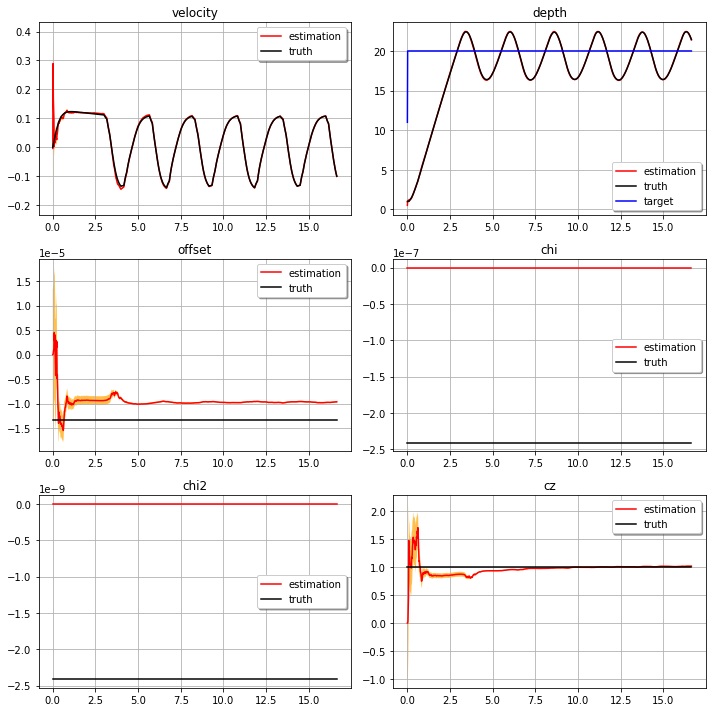

In [13]:
scale = 1e-6 # parameter use to turn off role of equivalent compressibility

_k.update({'gamma_init':np.array([_k['depth_error']/_k['dt'],
                                  _k['depth_error'],
                                  V_e_cst,
                                  f.gammaV*scale,
                                  f.gammaV/100.*scale, # 100m
                                  1.
                                ])**2
          })
# dynamics covariance:
_k.update({'gamma_alpha_scaled': np.array([acceleration_rho /1e1,
                                           acceleration_rho*_k['dt'] /1e2,
                                           V_e_cst/long_time_scale,
                                           f.gammaV/long_time_scale*scale,
                                           f.gammaV/100./long_time_scale*scale, # 100m
                                           1./long_time_scale
                                          ])**2
          })


f.time_step(w,T=Tsim, dt_step=.1, dt_log=1., z=z0, w=0., v=vstart,
            piston=True, z_target=z_target, ctrl=_c, kalman=_k, verbose=0)

_t = -(f.log['state']._df
       .set_index('time')[['w','z']]
       .rename(columns={'w': 'x_0', 'z': 'x_1'})
      )
_t['x_2'] = V_e_cst + _t['x_0']*0.
_t['x_3'] = gamma_e1_cst + _t['x_0']*0.
_t['x_4'] = gamma_e2_cst + _t['x_0']*0.
_t['x_5'] = 1. + _t['x_0']*0.

fl.plot_kalman(f.log, f, z_target=z_target, truth=_t, figsize=(10,10))

---

### Kalman filter with real physics

In [14]:
f = deepcopy(f0)

In [15]:
_k = {'version': 'v1', 'dt':.5, 'depth_error': 1e-1}

# initial state vector
_k.update({'x_init': [0., 0., 0., 0., 0., 0.],
          'gamma_init':np.array([_k['depth_error']/_k['dt'],
                                 _k['depth_error'],
                                 f.V*delta_rho/f.rho_cte,
                                 f.gammaV,
                                 f.gammaV/L_rho,
                                 1.,
                                 ])**2,
          'gamma_alpha_scaled': np.array([acceleration_rho*1e-1,
                                          acceleration_rho*_k['dt']*1e-2,
                                          target_velocity*V_e_rho/L_rho,
                                          target_velocity*V_e_rho/L_rho**2,
                                          target_velocity*V_e_rho/L_rho**3,
                                          1e-2,
                                          ])**2,
           'gamma_beta': np.diag([_k['depth_error']**2])
          })

f.time_step(w,T=Tsim, dt_step=.1, dt_log=1., z=z0, w=0., v=f.piston.vol_min,
            piston=True, z_target=z_target, ctrl=_c, kalman=_k, verbose=0)

Kalman filter: 
  dt     = 0.50 s     - filter time step
  x_hat   = [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00] - kalman state 
  sqrt(diag(gamma)): [2.00e-01 1.00e-01 2.47e-05 4.82e-08 4.82e-10 1.00e+00]
  sqrt(gamma_alpha) / dt: [9.52e-04 4.76e-05 2.47e-08 2.47e-10 2.47e-12 1.00e-02]
  sqrt(gamma_beta): [1.00e-01]
Start time stepping for 16 min ...
... time stepping done


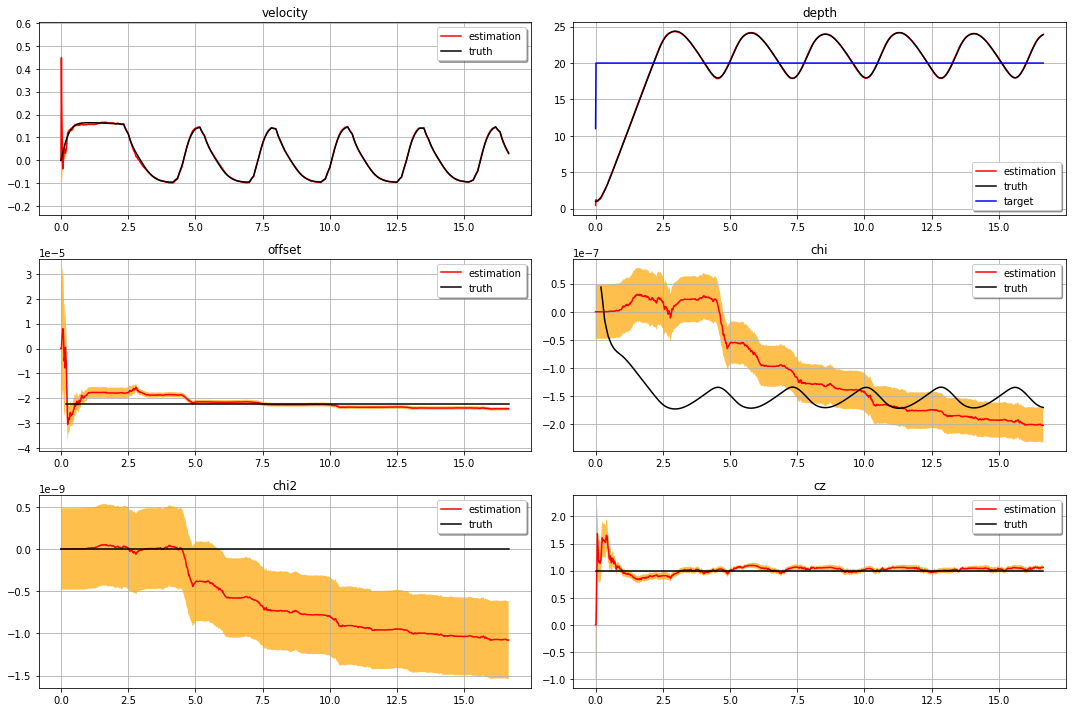

In [16]:
_t = -(f.log['state']._df
       .set_index('time')[['w','z']]
       .rename(columns={'w': 'x_0', 'z': 'x_1'})
      )
_t['x_2'] = interp1d(zm, V_e, kind='linear', bounds_error=False)(-_t['x_1'])
_t['x_3'] = interp1d(zm, gamma_e, kind='linear', bounds_error=False)(-_t['x_1'])
_t['x_4'] = 0. + _t['x_0']*0.
_t['x_5'] = 1. + _t['x_0']*0.

fl.plot_kalman(f.log, f, z_target=z_target, truth=_t, figsize=(15,10))

In [17]:
f.kalman.to_seabot(f)

 gamma_alpha_velocity: 4.76e-04
 gamma_alpha_depth: 2.38e-05
 gamma_alpha_offset: 4.83e-01
 gamma_alpha_chi: 4.83e-03
 gamma_alpha_chi2: 4.83e-05
 gamma_alpha_cz: 0.005
 gamma_init_velocity: 2.00e-01
 gamma_init_depth: 1.00e-01
 gamma_init_offset: 9.67e+02
 gamma_init_chi: 1.88e+00
 gamma_init_chi2: 1.88e-02
 gamma_init_cz: 1.00e+00
 gamma_beta_depth: 1.00e-01
 init_chi: 0.00e+00
 init_chi2: 0.00e+00


---

### Kalman filter with feedback regulation


Kalman filter: 
  dt     = 0.50 s     - filter time step
  x_hat   = [0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00, 0.00e+00] - kalman state 
  sqrt(diag(gamma)): [2.00e-01 1.00e-01 2.47e-05 4.82e-08 4.82e-10 1.00e+00]
  sqrt(gamma_alpha) / dt: [9.52e-04 4.76e-05 2.47e-08 2.47e-10 2.47e-12 1.00e-02]
  sqrt(gamma_beta): [1.00e-01]
Start time stepping for 16 min ...
... time stepping done
Extrapolated energy conssumption: 4.6e-03 Wh/day = 0.1 Wh/30day


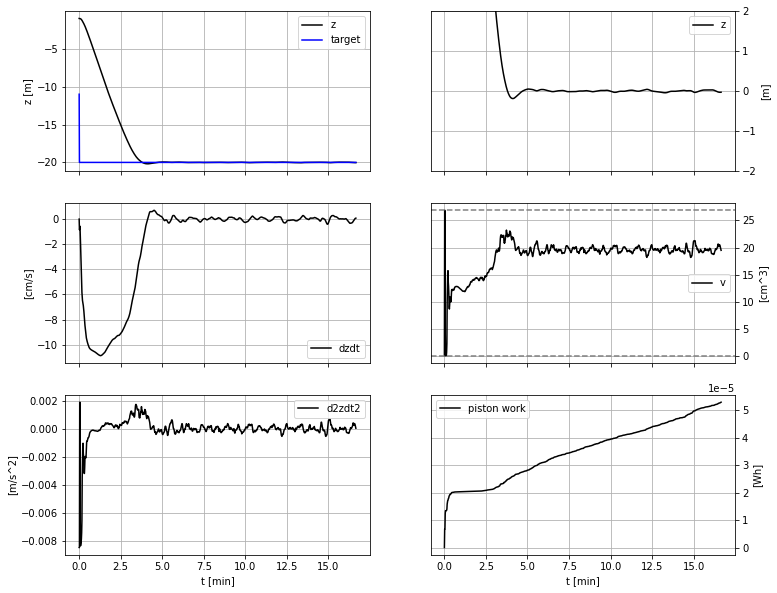

In [18]:
_k = {'version': 'v1', 'dt':.5, 'depth_error': 1e-1}

# initial state vector
_k.update({'x_init': [0., 0., 0., 0., 0., 0.],
          'gamma_init':np.array([_k['depth_error']/_k['dt'],
                                 _k['depth_error'],
                                 f.V*delta_rho/f.rho_cte,
                                 f.gammaV,
                                 f.gammaV/L_rho,
                                 1.,
                                 ])**2,
          'gamma_alpha_scaled': np.array([acceleration_rho*1e-1,
                                          acceleration_rho*_k['dt']*1e-2,
                                          target_velocity*V_e_rho/L_rho,
                                          target_velocity*V_e_rho/L_rho**2,
                                          target_velocity*V_e_rho/L_rho**3,
                                          1e-2,
                                          ])**2,
           'gamma_beta': np.diag([_k['depth_error']**2])
          })

_c = {'mode': 'kalman_feedback2', 'dt': 1., 'dz_nochattering': 0.,
      'nu': target_velocity*2./np.pi, 'tau': 5., 'delta': 1., 
      'continuous': False
     }

f.time_step(w, T=Tsim, dt_step=.1, dt_log=1., z=z0, w=0., v=f.piston.vol_min,
            piston=True, z_target=z_target, ctrl=_c, kalman=_k, verbose=0)
f.plot_logs(z_target=z_target)

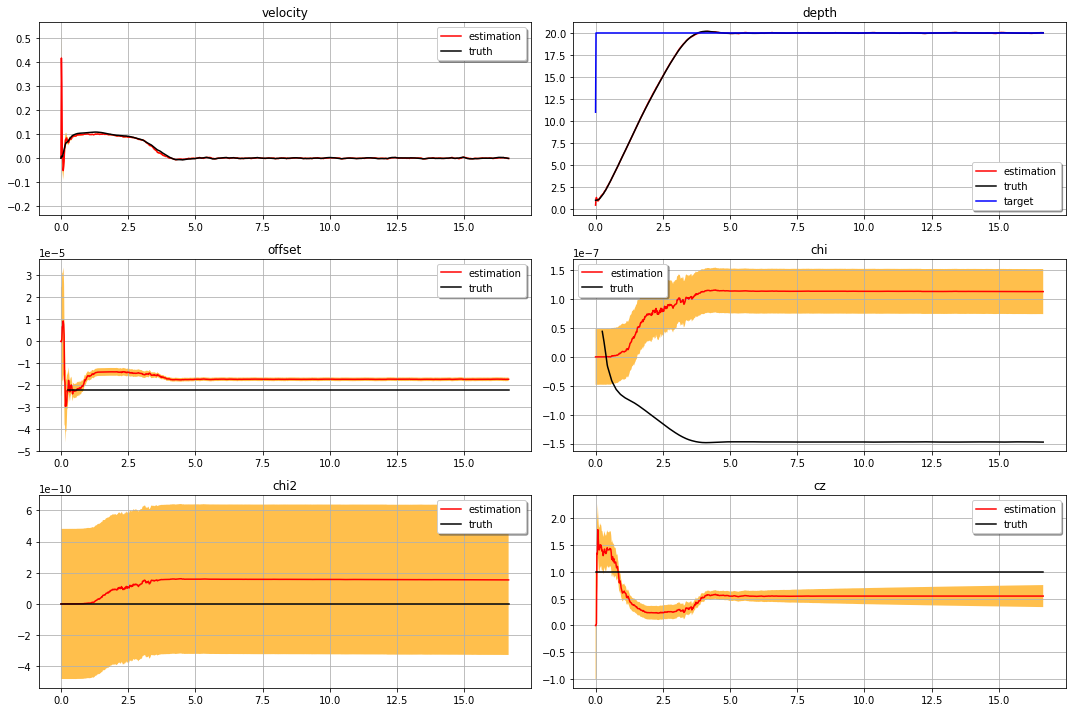

In [19]:
_t = -(f.log['state']._df
       .set_index('time')[['w','z']]
       .rename(columns={'w': 'x_0', 'z': 'x_1'})
      )
_t['x_2'] = interp1d(zm, V_e, kind='linear', bounds_error=False)(-_t['x_1'])
_t['x_3'] = interp1d(zm, gamma_e, kind='linear', bounds_error=False)(-_t['x_1'])
_t['x_4'] = 0. + _t['x_0']*0.
_t['x_5'] = 1. + _t['x_0']*0.

fl.plot_kalman(f.log, f, z_target=z_target, truth=_t, figsize=(15,10))

In [20]:
f.log['control'].plot_bk(size=(400, 200))

Loading BokehJS ...

In [21]:
f.log['dynamics'].plot_bk(gridded=False)

Loading BokehJS ...

### Suggestion TLM:

pendant descente: bruit peut-être réglé par l'astuce avec l'interval de vitesse autour de nu

au niveau du plateau, le bruit génère les fluctuations observées, améliorable avec le lissage des mesures de pression

---

### now increase time steps

!!! Needs to be updated !!!

In [22]:
scale = 2.

_k = {'dt':0.5*scale, 'depth_error': 1e-2}

_k.update({'gamma_e0': -2*f.gammaV, 'V_e0': 0.,
           'gamma':np.array([_k['depth_error']/_k['dt'],
                             _k['depth_error'],
                             f.gammaV,
                             f.V*delta_rho/f.rho_cte,
                            ])**2,
           'gamma_alpha_scaled': np.array([acceleration_rho,
                                           acceleration_rho*_k['dt'],
                                           target_velocity*V_e_rho/L_rho**2,
                                           target_velocity*V_e_rho/L_rho,
                                           ])**2 *1e0})

_c = {'mode': 'kalman_feedback2', 'dt': 5.*scale, 'dz_nochattering': 0.,
      'nu': 2*target_velocity*2./np.pi, 'tau': 10.*scale, 'delta': 1.,
      'continuous': False,
     }

f.time_step(w,T=Tsim, dt_step=.1, dt_log=1., z=z0, w=0., v=f.piston.vol_min,
            piston=True, z_target=z_target, ctrl=_c, kalman=_k, verbose=0)

V_e_z = interp1d(zm, V_e, kind='linear', bounds_error=False)(f.log['state']['z'].values)
gamma_e_z = interp1d(zm, gamma_e, kind='linear', bounds_error=False)(f.log['state']['z'].values)

fl.plot_kalman(f.log, f, V_e = V_e_z, gamma_e = gamma_e_z, z_target=z_target)

AssertionError: Kalman filter parameters should include: m, a, rho_cte, x_init, gamma_init

In [ ]:
scale = 5.

_k = {'dt':0.5*scale, 'depth_error': 1e-2}

_k.update({'gamma_e0': -2*f.gammaV, 'V_e0': 0.,
           'gamma':np.array([_k['depth_error']/_k['dt'],
                             _k['depth_error'],
                             f.gammaV,
                             f.V*delta_rho/f.rho_cte,
                            ])**2,
           'gamma_alpha_scaled': np.array([acceleration_rho,
                                           acceleration_rho*_k['dt'],
                                           target_velocity*V_e_rho/L_rho**2,
                                           target_velocity*V_e_rho/L_rho,
                                           ])**2 *1e0})

_c = {'mode': 'kalman_feedback2', 'dt': 5.*scale, 'dz_nochattering': 0.,
      'nu': 2*target_velocity*2./np.pi, 'tau': 10.*scale, 'delta': 1.,
      'continuous': False,
     }

f.time_step(w,T=Tsim, dt_step=.1, dt_log=1., z=z0, w=0., v=f.piston.vol_min,
            piston=True, z_target=z_target, ctrl=_c, kalman=_k, verbose=0)

V_e_z = interp1d(zm, V_e, kind='linear', bounds_error=False)(f.log['state']['z'].values)
gamma_e_z = interp1d(zm, gamma_e, kind='linear', bounds_error=False)(f.log['state']['z'].values)

fl.plot_kalman(f.log, f, V_e = V_e_z, gamma_e = gamma_e_z, z_target=z_target)

In [ ]:
print(f.kalman.A_coeff, f.kalman.B_coeff)